## 3. Predict the number of unique URL visits by a given IP

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, to_timestamp, col, when, sum, avg, count, split, explode, udf, collect_list, monotonically_increasing_id, row_number, size
from pyspark import Row
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import ArrayType, TimestampType
import datetime
from matplotlib import pyplot as plt

In [2]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
sc = SparkContext.getOrCreate()

In [4]:
spark = SparkSession.builder.getOrCreate()

In [5]:
df = spark.read \
       .format("csv") \
       .option("header", "true") \
       .option("inferSchema", "true") \
       .load("data/unique_ip/*.csv")

In [6]:
df.limit(10).toPandas()

,user_id,counts
0,1.186.224.199,1
1,1.187.125.168,2
2,1.187.168.229,7
3,1.187.226.117,3
4,1.22.115.112,5
5,1.22.190.88,3
6,1.38.18.9,6
7,1.38.23.127,10
8,1.38.23.127,1
9,1.39.11.237,2


In [7]:
df.dtypes

[('user_id', 'string'), ('counts', 'int')]

In [8]:
df = df.withColumnRenamed('counts', 'label')
df.show()

+-------------+-----+
|      user_id|label|
+-------------+-----+
|1.186.224.199|    1|
|1.187.125.168|    2|
|1.187.168.229|    7|
|1.187.226.117|    3|
| 1.22.115.112|    5|
|  1.22.190.88|    3|
|    1.38.18.9|    6|
|  1.38.23.127|   10|
|  1.38.23.127|    1|
|  1.39.11.237|    2|
|  1.39.15.166|    2|
|  1.39.15.166|    1|
|  1.39.32.209|    3|
|  1.39.32.228|    4|
|   1.39.32.46|    2|
|  1.39.34.192|    1|
|  1.39.62.243|    1|
|   1.39.63.31|    9|
|   1.39.63.31|    1|
|  1.39.80.104|    2|
+-------------+-----+
only showing top 20 rows



In [9]:
df = df.withColumn('ip', split(col('user_id'), '\.'))
df.show()

+-------------+-----+------------------+
|      user_id|label|                ip|
+-------------+-----+------------------+
|1.186.224.199|    1|[1, 186, 224, 199]|
|1.187.125.168|    2|[1, 187, 125, 168]|
|1.187.168.229|    7|[1, 187, 168, 229]|
|1.187.226.117|    3|[1, 187, 226, 117]|
| 1.22.115.112|    5| [1, 22, 115, 112]|
|  1.22.190.88|    3|  [1, 22, 190, 88]|
|    1.38.18.9|    6|    [1, 38, 18, 9]|
|  1.38.23.127|   10|  [1, 38, 23, 127]|
|  1.38.23.127|    1|  [1, 38, 23, 127]|
|  1.39.11.237|    2|  [1, 39, 11, 237]|
|  1.39.15.166|    2|  [1, 39, 15, 166]|
|  1.39.15.166|    1|  [1, 39, 15, 166]|
|  1.39.32.209|    3|  [1, 39, 32, 209]|
|  1.39.32.228|    4|  [1, 39, 32, 228]|
|   1.39.32.46|    2|   [1, 39, 32, 46]|
|  1.39.34.192|    1|  [1, 39, 34, 192]|
|  1.39.62.243|    1|  [1, 39, 62, 243]|
|   1.39.63.31|    9|   [1, 39, 63, 31]|
|   1.39.63.31|    1|   [1, 39, 63, 31]|
|  1.39.80.104|    2|  [1, 39, 80, 104]|
+-------------+-----+------------------+
only showing top

In [10]:
df.dtypes

[('user_id', 'string'), ('label', 'int'), ('ip', 'array<string>')]

In [11]:
df = df.select(df.ip[0].alias('ip_0'), df.ip[1].alias('ip_1'), df.ip[2].alias('ip_2'), df.ip[3].alias('ip_3'), 'label')

In [12]:
features = [f for f in df.schema.names if f != 'label']
features

['ip_0', 'ip_1', 'ip_2', 'ip_3']

In [13]:
for feature in features:
    indexer = StringIndexer(inputCol=feature, outputCol=feature + '_ix')
    df = indexer.fit(df).transform(df)
df.show()

+----+----+----+----+-----+-------+-------+-------+-------+
|ip_0|ip_1|ip_2|ip_3|label|ip_0_ix|ip_1_ix|ip_2_ix|ip_3_ix|
+----+----+----+----+-----+-------+-------+-------+-------+
|   1| 186| 224| 199|    1|    3.0|  132.0|   17.0|  210.0|
|   1| 187| 125| 168|    2|    3.0|   40.0|  108.0|  199.0|
|   1| 187| 168| 229|    7|    3.0|   40.0|  128.0|  128.0|
|   1| 187| 226| 117|    3|    3.0|   40.0|   60.0|  111.0|
|   1|  22| 115| 112|    5|    3.0|   58.0|  252.0|  121.0|
|   1|  22| 190|  88|    3|    3.0|   58.0|  229.0|  197.0|
|   1|  38|  18|   9|    6|    3.0|   34.0|   40.0|   59.0|
|   1|  38|  23| 127|   10|    3.0|   34.0|   52.0|  252.0|
|   1|  38|  23| 127|    1|    3.0|   34.0|   52.0|  252.0|
|   1|  39|  11| 237|    2|    3.0|    0.0|   50.0|  239.0|
|   1|  39|  15| 166|    2|    3.0|    0.0|    6.0|   48.0|
|   1|  39|  15| 166|    1|    3.0|    0.0|    6.0|   48.0|
|   1|  39|  32| 209|    3|    3.0|    0.0|   16.0|  212.0|
|   1|  39|  32| 228|    4|    3.0|    0

In [14]:
features = [f + '_ix' for f in features]
features

['ip_0_ix', 'ip_1_ix', 'ip_2_ix', 'ip_3_ix']

In [15]:
ohe_features = [f + '_ohe' for f in features]
ohe_features

['ip_0_ix_ohe', 'ip_1_ix_ohe', 'ip_2_ix_ohe', 'ip_3_ix_ohe']

In [16]:
ohe = OneHotEncoder(inputCols=features, outputCols=ohe_features)
transformer = ohe.fit(df)

In [17]:
df = transformer.transform(df)

In [18]:
df.show()

+----+----+----+----+-----+-------+-------+-------+-------+---------------+-----------------+-----------------+-----------------+
|ip_0|ip_1|ip_2|ip_3|label|ip_0_ix|ip_1_ix|ip_2_ix|ip_3_ix|    ip_0_ix_ohe|      ip_1_ix_ohe|      ip_2_ix_ohe|      ip_3_ix_ohe|
+----+----+----+----+-----+-------+-------+-------+-------+---------------+-----------------+-----------------+-----------------+
|   1| 186| 224| 199|    1|    3.0|  132.0|   17.0|  210.0|(191,[3],[1.0])|(255,[132],[1.0])| (255,[17],[1.0])|(255,[210],[1.0])|
|   1| 187| 125| 168|    2|    3.0|   40.0|  108.0|  199.0|(191,[3],[1.0])| (255,[40],[1.0])|(255,[108],[1.0])|(255,[199],[1.0])|
|   1| 187| 168| 229|    7|    3.0|   40.0|  128.0|  128.0|(191,[3],[1.0])| (255,[40],[1.0])|(255,[128],[1.0])|(255,[128],[1.0])|
|   1| 187| 226| 117|    3|    3.0|   40.0|   60.0|  111.0|(191,[3],[1.0])| (255,[40],[1.0])| (255,[60],[1.0])|(255,[111],[1.0])|
|   1|  22| 115| 112|    5|    3.0|   58.0|  252.0|  121.0|(191,[3],[1.0])| (255,[58],[1.0

In [19]:
va = VectorAssembler(inputCols=ohe_features, outputCol='features')
df = va.transform(df)

In [20]:
df.show()

+----+----+----+----+-----+-------+-------+-------+-------+---------------+-----------------+-----------------+-----------------+--------------------+
|ip_0|ip_1|ip_2|ip_3|label|ip_0_ix|ip_1_ix|ip_2_ix|ip_3_ix|    ip_0_ix_ohe|      ip_1_ix_ohe|      ip_2_ix_ohe|      ip_3_ix_ohe|            features|
+----+----+----+----+-----+-------+-------+-------+-------+---------------+-----------------+-----------------+-----------------+--------------------+
|   1| 186| 224| 199|    1|    3.0|  132.0|   17.0|  210.0|(191,[3],[1.0])|(255,[132],[1.0])| (255,[17],[1.0])|(255,[210],[1.0])|(956,[3,323,463,9...|
|   1| 187| 125| 168|    2|    3.0|   40.0|  108.0|  199.0|(191,[3],[1.0])| (255,[40],[1.0])|(255,[108],[1.0])|(255,[199],[1.0])|(956,[3,231,554,9...|
|   1| 187| 168| 229|    7|    3.0|   40.0|  128.0|  128.0|(191,[3],[1.0])| (255,[40],[1.0])|(255,[128],[1.0])|(255,[128],[1.0])|(956,[3,231,574,8...|
|   1| 187| 226| 117|    3|    3.0|   40.0|   60.0|  111.0|(191,[3],[1.0])| (255,[40],[1.0])| 

In [21]:
df.count()

110835

In [22]:
df.dtypes

[('ip_0', 'string'),
 ('ip_1', 'string'),
 ('ip_2', 'string'),
 ('ip_3', 'string'),
 ('label', 'int'),
 ('ip_0_ix', 'double'),
 ('ip_1_ix', 'double'),
 ('ip_2_ix', 'double'),
 ('ip_3_ix', 'double'),
 ('ip_0_ix_ohe', 'vector'),
 ('ip_1_ix_ohe', 'vector'),
 ('ip_2_ix_ohe', 'vector'),
 ('ip_3_ix_ohe', 'vector'),
 ('features', 'vector')]

In [23]:
train, test = df.randomSplit([0.7, 0.3], seed=2020)
train.count(), test.count()

(77565, 33270)

In [24]:
algorithm = LinearRegression(featuresCol="features", )

model = algorithm.fit(train)               

predictions = model.transform(test)

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")    

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.18355


In [25]:
results = predictions.select('label', 'prediction').sample(withReplacement=True, fraction=0.001, seed=2020).toPandas()
results

,label,prediction
0,3,4.317265
1,3,3.383198
2,3,3.986600
3,10,3.177273
4,2,5.680509
5,5,5.807506
6,5,5.802236
7,9,3.867706
8,6,4.451409
9,2,3.387087


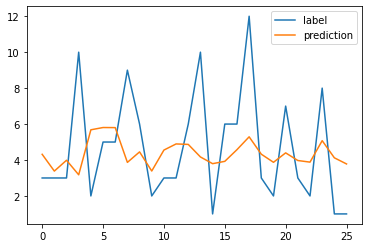

In [26]:
plt.plot(results.index, results.label)
plt.plot(results.index, results.prediction)
plt.legend(['label', 'prediction'])
plt.show()

In [27]:
spark.stop()